```
This notebook is a part of RAGexperimental repository available at https://github.com/kumarsandeep567/RAGexperimental/
```

# Problems with Retrieval Augmented Generation or RAG

After working on `Part1` of the RAGexperimental repository, we have a good understanding of how our RAG application works.

To recall:
- We have our document (which was [this blog post](https://lilianweng.github.io/posts/2023-06-23-agent/)), which is broken down into chunks, and each chunk is converted to vector embeddings via OpenAI's vector embeddings API, and each of these vector embedding is stored and indexed in a vector store (in this case, Chroma vector store).
- We take the user's query, convert it to vector embeddings, and perform a cosine similarity search, where the vector embeddings of the query are compared with all the vector embeddings available in the vector store, and based on our criteria, we fetch 'x' number of chunks from the vector store, which becomes the context we need for our query.
- Later we pass it to our Large Language Model (LLM) to answer the query based on the provided context.

Upon understanding carefully, you'll notice that our context is fetched on the basis of our query. 

## What if our query is ambiguous?

<center>
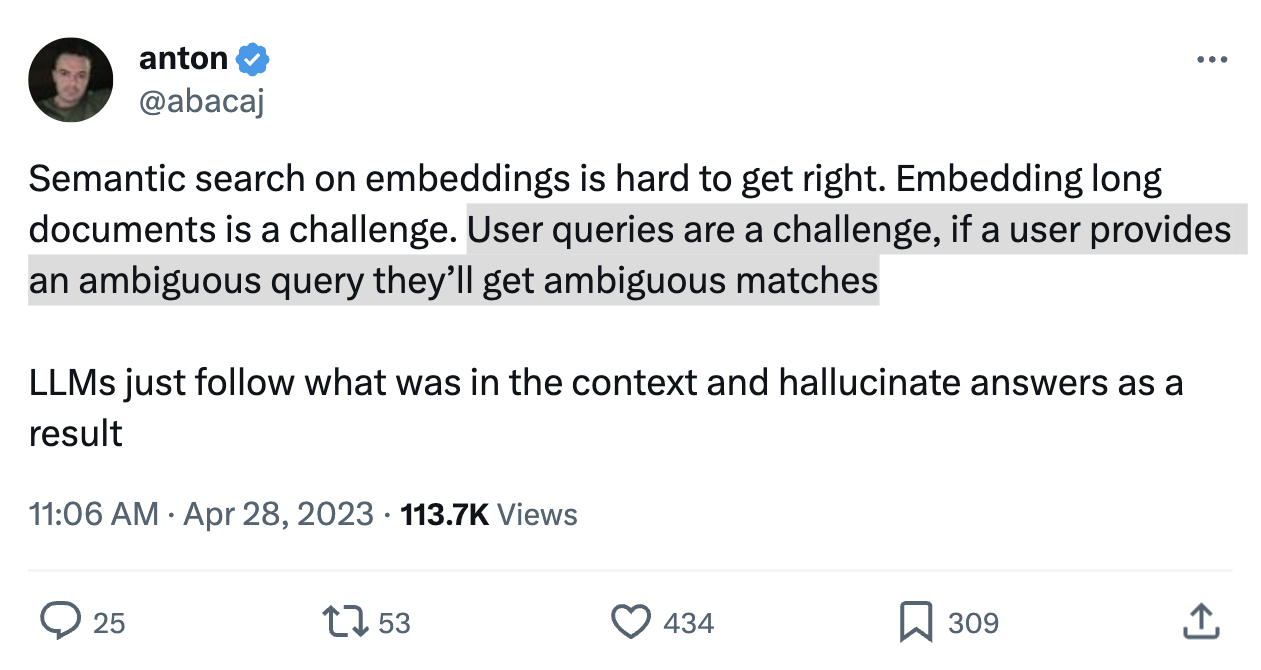
</center>

If our query is poorly structured, our cosine similarity matching will fail to fetch context that is actually relevant to the query.

This brings up the question, how do we convert the ambiguous query to a non-ambiguous one?

# Query Transformations

- **Query transformations** is one of the approaches to solve the "ambiguous query" problem. \
Query transformation deals with transformations of the user's question before passing to the embedding model.

For performing query transformations, we can chose one of the three strategies available. The core difference between each strategy is the level of abstraction.

<center>
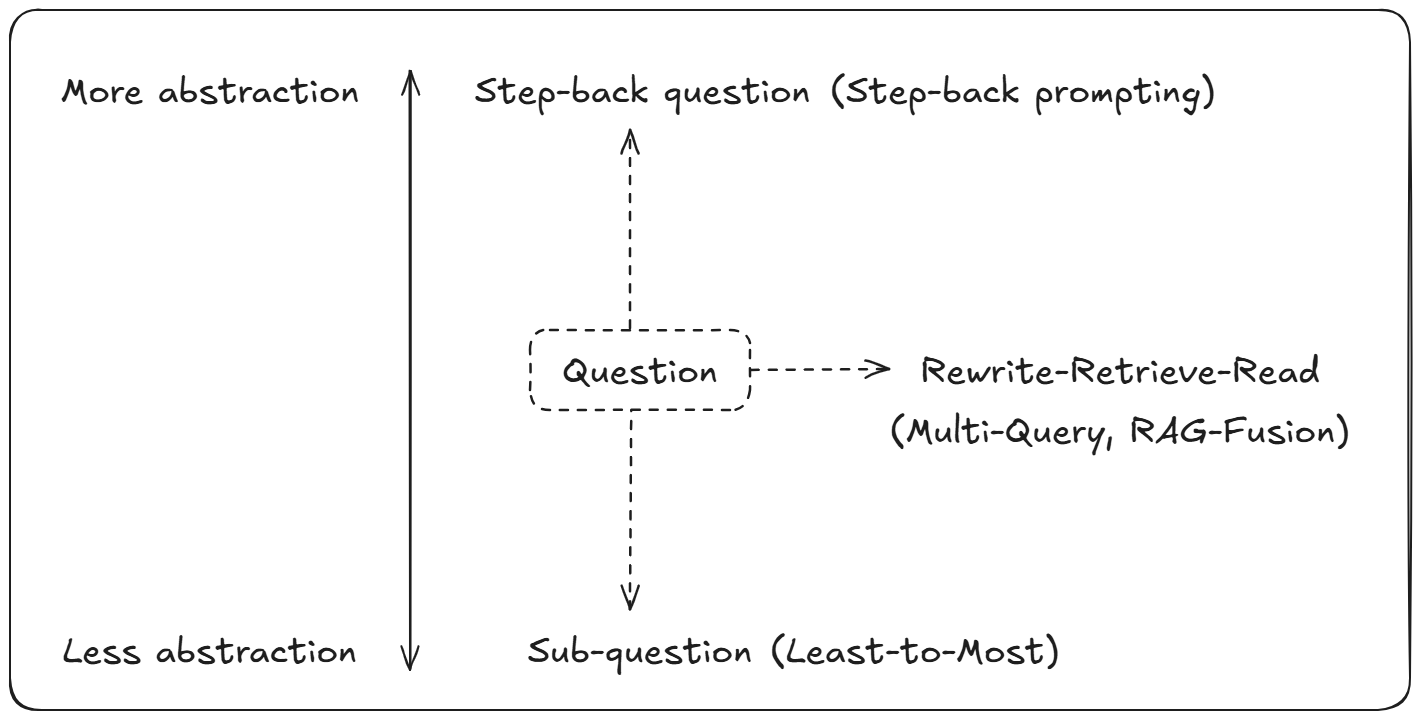
</center>

## 1. Rewrite-Retrieve-Read

- If you think of a naive RAG pipeline, the general flow is that you take the users question and pass that directly to an embedding model. That embedding is then compared to documents stored in the vectorstore, and the top k most similar ones are returned.

<center>
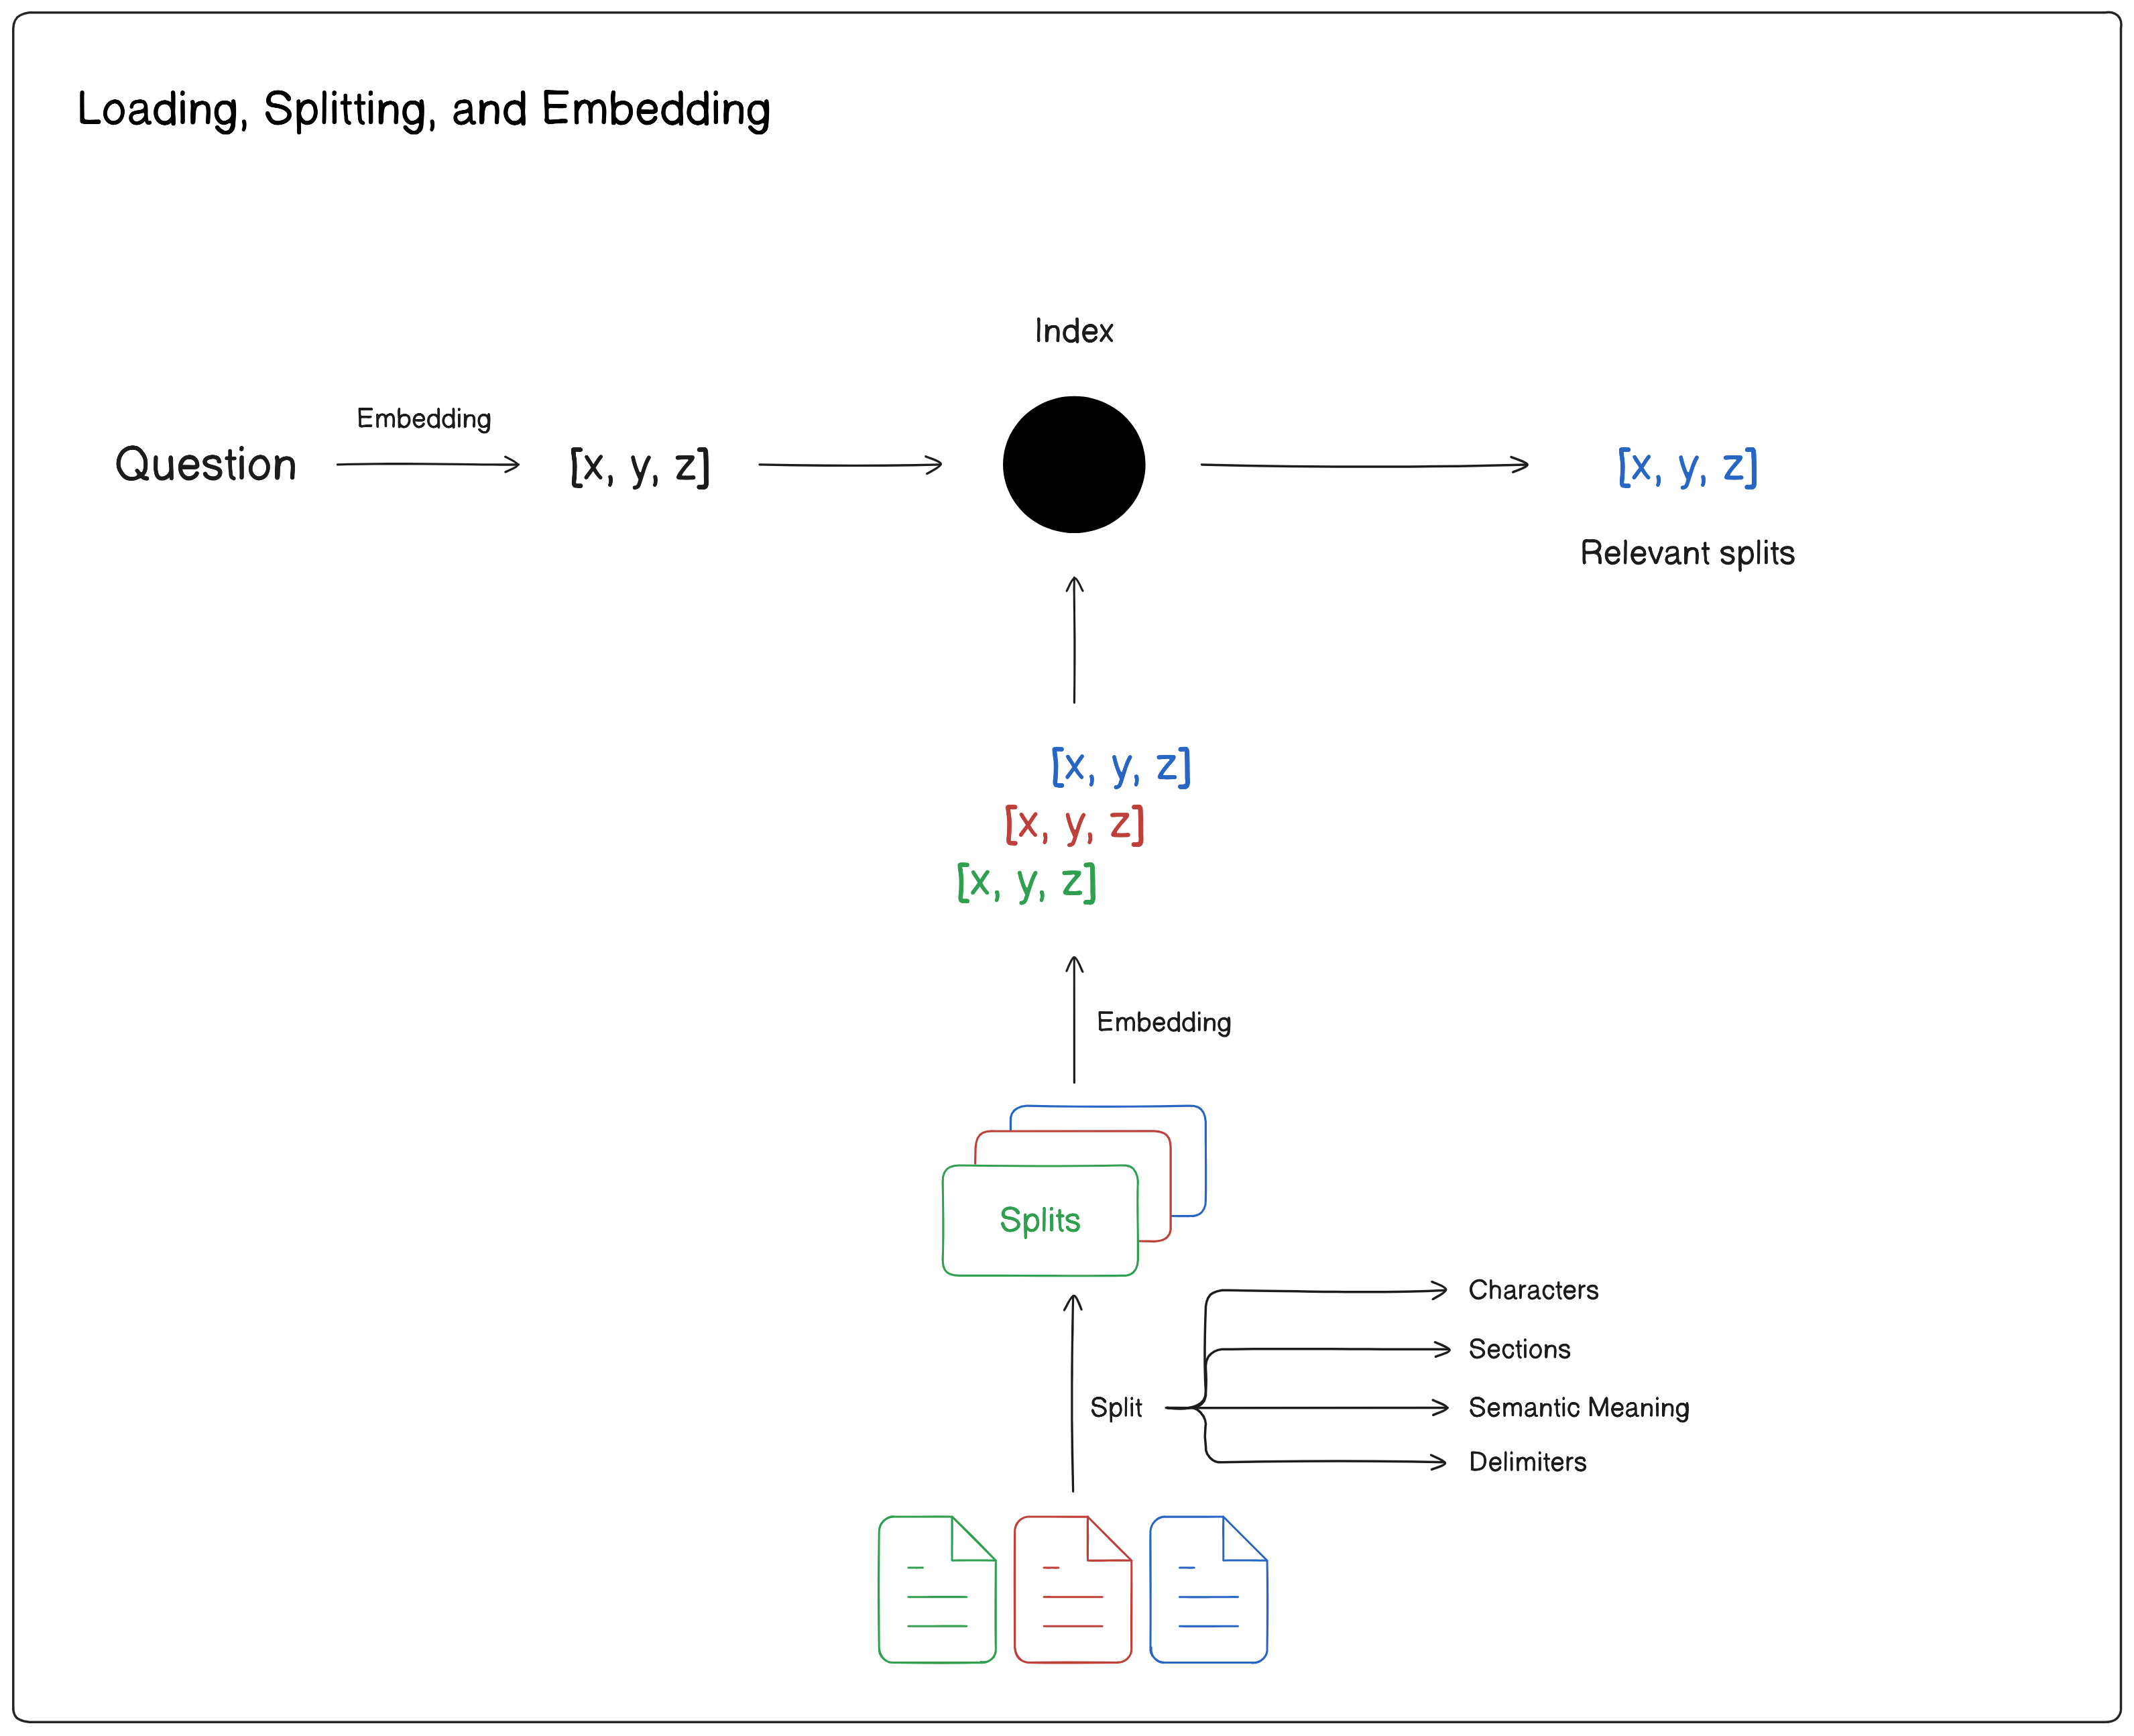
</center>

- Because this naive RAG implementation would be pretty inefficient for ambiguous queries, we introduce the concept of **"Rewrite-Retrieve-Read"**.
- The core idea behind this approach is that we pass the question to the LLM and ask it to rewrite the question in various ways, hereby curating a list of different ways we could ask the same question. 
- Now, Rewrite-Retrieve-Read can be implemented in two ways: 
    - Multi-Query
    - RAG Fusion

### 1.1 Multi-Query

The Multi-Query approach is the simplest implementation of Rewrite-Retrieve-Read.
- We simply pass the question to the LLM, and ask it to rewrite the question in various ways, and save all the variations of the question.
- For each variation of the question, we lookup the relevant chunks in the vector store, and curate a list of relevant chunks.
- We bundle all fetched chunks as a large context, and pass it to the LLM with the question.

<center>

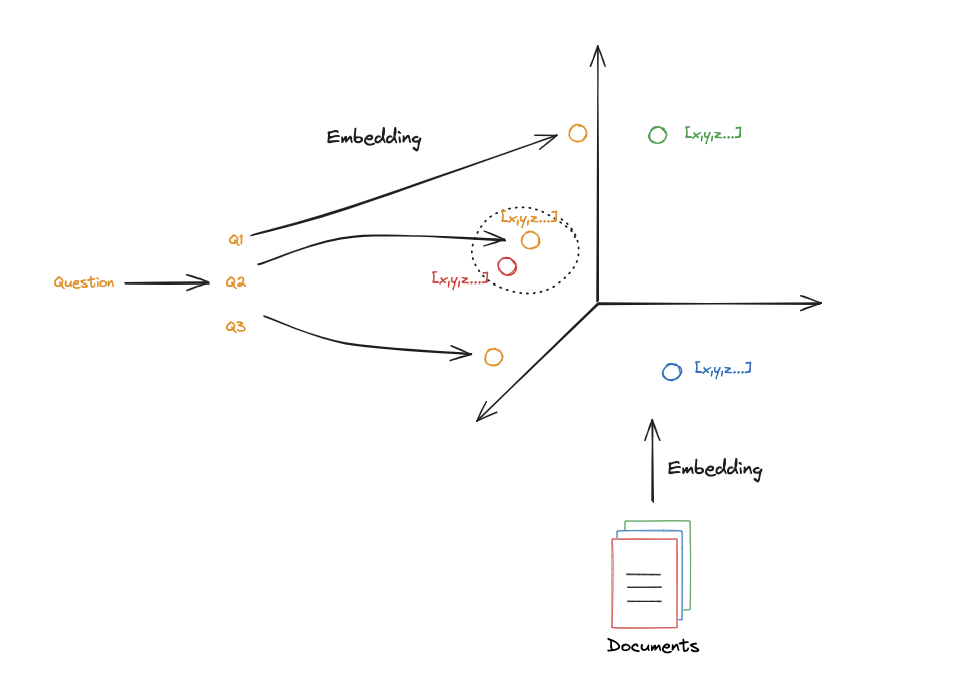

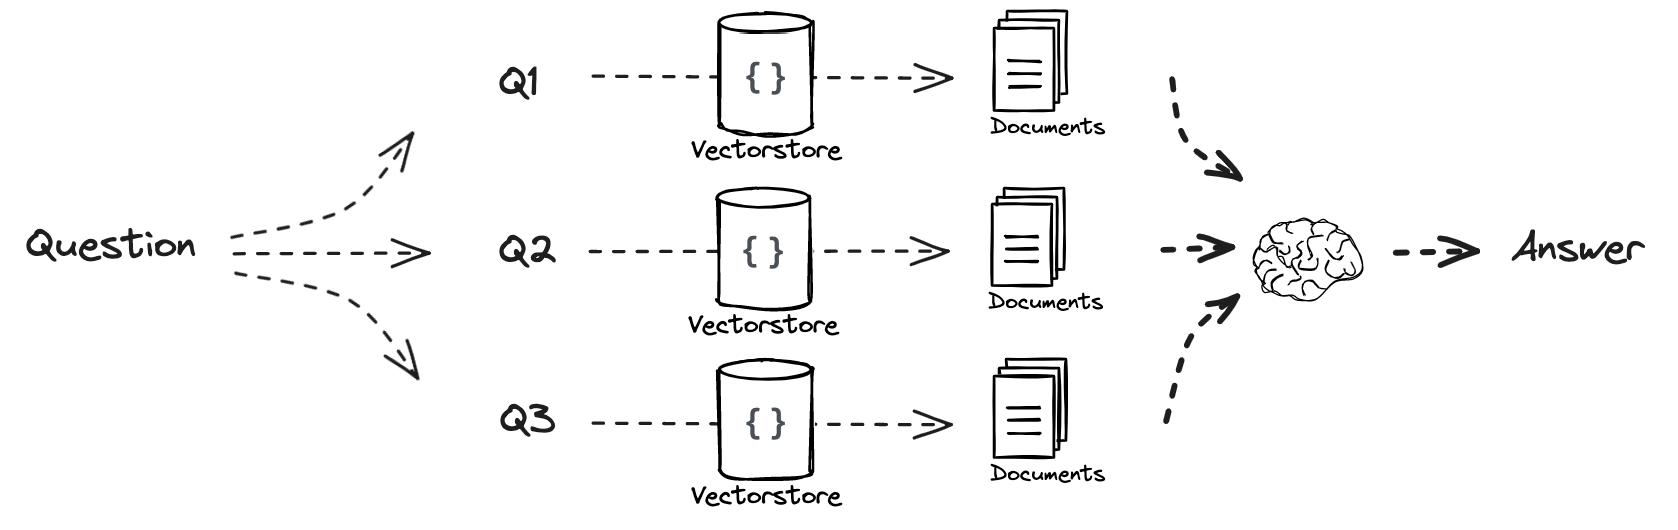

</center>

Let's try implementing a Multi-Query Retriever with LangChain. We'll use the ChromaDB vectorstore created in `Part1` which contains the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog authored by [Lilian Weng](https://www.linkedin.com/in/lilianweng).

In [14]:
# Same code copied from Part1 notebook

import os
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


vectorstore = Chroma(
    collection_name    = "github_blog_collection",
    persist_directory  = "./rag_with_langchain_database",
    embedding_function = OpenAIEmbeddings(
        model   = "text-embedding-3-large",
        api_key = os.getenv("OPENAI_API_KEY", None)
    )
)

Now, as discussed in the above points, we need to pass the user's query to the LLM and ask the LLM to rewrite it in multiple ways.
To achieve this, we can either create our own prompt via the `ChatPromptTemplate` or pull a prompt from the prompt hub.

Let's take a look at the prompt available on the prompt hub.

In [15]:
from langchain import hub

rewrite_prompt = hub.pull("langchain-ai/rewrite")

rewrite_prompt.template

'Provide a better search query for web search engine to answer the given question, end the queries with ’**’.  Question {x} Answer:'

Well that looks.. disappointing. The good news is, we can write our own prompt! 

In [16]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import os

# Define the prompt template
rewrite_prompt_template = """
You are an AI language model assistant. 
Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database. 
By generating multiple perspectives on the user question, your goal is to help the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}
"""

new_prompts = ChatPromptTemplate.from_template(template=rewrite_prompt_template)

llm = ChatOpenAI(
    model       = "gpt-4o",
    api_key     = os.getenv("OPENAI_API_KEY", None),
    temperature = 0
)

# Define the pipeline, with output processing to split by newlines
generate_new_queries = (
    new_prompts
    | llm
    | StrOutputParser()
    | (lambda line: line.split("\n"))
)

# User query
query = "What are the approaches to Task Decomposition?"

# Invoke the pipeline
new_queries = generate_new_queries.invoke({"question": query})

new_queries

['What methods are used for breaking down tasks into smaller components?  ',
 'How can tasks be effectively decomposed into manageable parts?  ',
 'What strategies exist for task decomposition in project management?  ',
 'What are the techniques for dividing tasks into sub-tasks?  ',
 'How do experts approach the process of task decomposition?  ']

Great! With our query rewrite logic, we rewrote the user's query in 5 different ways.

Now let's run each of these query against our vector database and check if the number of relevant chunks increases or not.

In [30]:
from langchain.load import loads, dumps

def merge_chunks(docs):
    """ Combine all the unique chunks retrieved from the vector store """

    # Flatten the list of lists, and convert each chunk to string
    chunks_flattened = [dumps(doc) for doc_list in docs for doc in doc_list]

    # Fetch unique chunks
    unique_chunks = list(set(chunks_flattened))

    return [loads(doc) for doc in unique_chunks]


# User query
query = "What are the approaches to Task Decomposition?"

# Define a chunk retrieval pipeline for our rewrite-retrieve-read logic
retriever = vectorstore.as_retriever(
    search_type = "similarity_score_threshold",
    search_kwargs = {
        "k": 6,
        "score_threshold": 0.1
    }
)
retrieval_chain = generate_new_queries | retriever.map() | merge_chunks

# Check how many chunks were retrieved
relevant_documents = retrieval_chain.invoke({
    "question" : query
})

print("Number of relevant chunks retrieved: ", len(relevant_documents))

c:\Users\Pigeon\anaconda3\envs\rag_env\lib\site-packages\langchain_core\vectorstores\base.py:1083: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), 0.147857785443965), (Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',

Number of relevant chunks retrieved:  6


In [31]:
relevant_documents

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 17803}, page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" field denotes the id of the previous task which generates a new resource that the current task relies on. A special tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From this chat history, you can find the path of the user-mentioned resources for your task planning.'),
 Document(metadat

We found `6` relevant chunks, which is higher than the `3` relevant chunks we found in `Part1`

Now let's connect the Rewrite-Retrieve-Read Multi-Query pipeline with our RAG pipeline and produce a final result.

In [32]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

prompt_template = """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use ten sentences maximum and keep the answer concise.

Relevant context for the upcoming question:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template=prompt_template)

# RAG chain with rewrite-retrieve-read
final_rag_chain = (
    {
        "context"   : retrieval_chain, 
        "question"  : itemgetter("question")
    } 
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in final_rag_chain.stream({"question": query}):
    print(chunk, end="", flush=True)

c:\Users\Pigeon\anaconda3\envs\rag_env\lib\site-packages\langchain_core\vectorstores\base.py:1083: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), 0.1088463031821083), (Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'

The approaches to Task Decomposition include:

1. **Chain of Thought (CoT)**: This technique involves instructing the model to "think step by step" to break down complex tasks into smaller, manageable steps, enhancing model performance on intricate tasks.

2. **Tree of Thoughts**: This method extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure of thoughts. It involves decomposing the problem into multiple thought steps and generating multiple thoughts per step, with the search process being either breadth-first or depth-first.

3. **LLM with Simple Prompting**: This involves using straightforward prompts to guide the decomposition process, such as asking for the steps or subgoals needed to achieve a particular task.

4. **Task-Specific Instructions**: This approach uses specific instructions tailored to the task at hand, such as "Write a story outline" for writing a novel.

5. **Human Inputs**: Incorporating human inputs to assist in breaki

### 1.2 RAG Fusion

- In our Multi-Query approach, we rewrite our question in various ways through an LLM, and for each variation, we fetch the relevant context from the vector store.
- Because there are multiple variations of the same question, it is very likely that our RAG may fetch different kinds of relevant documents from the vector store, forming a larger context for our question.
- While all the documents are relevant with regards to the question, are all documents equally relevant? RAG Fusion solves this by introducing Reciprocal Rank Fusion.

**Reciprocal Rank Fusion (RRF)** is a technique for combining the ranks of multiple search result lists to produce a single, unified ranking. It works by aggregating rankings from different search queries or retrieval systems. The technique is especially useful when dealing with multiple sources or retrieval models.

- **RRF is most beneficial when multiple search engines or systems are used to retrieve documents**, as it allows for the aggregation of results from systems that might rank documents differently. By combining the ranks from these diverse sources, RRF helps ensure that highly relevant documents, which might be ranked differently across various models or queries, are prioritized.

- In our case, RAG Fusion with RRF ensures that even if different queries return slightly different relevant chunks from the vector store, the final ranking reflects a more comprehensive view of relevance. RRF boosts the chances that the most relevant chunks will appear at the top of the final list, giving us a more refined and accurate context for the question.


$$
\begin{aligned}
RRFscore(d \in D) &= \sum_{r \in R} \frac{1}{k + r(d)} \\
\text{where:} & \\
D &= \text{set of documents to be ranked} \\
R &= \text{set of rankings} \\
k &= 60
\end{aligned}
$$

<center>
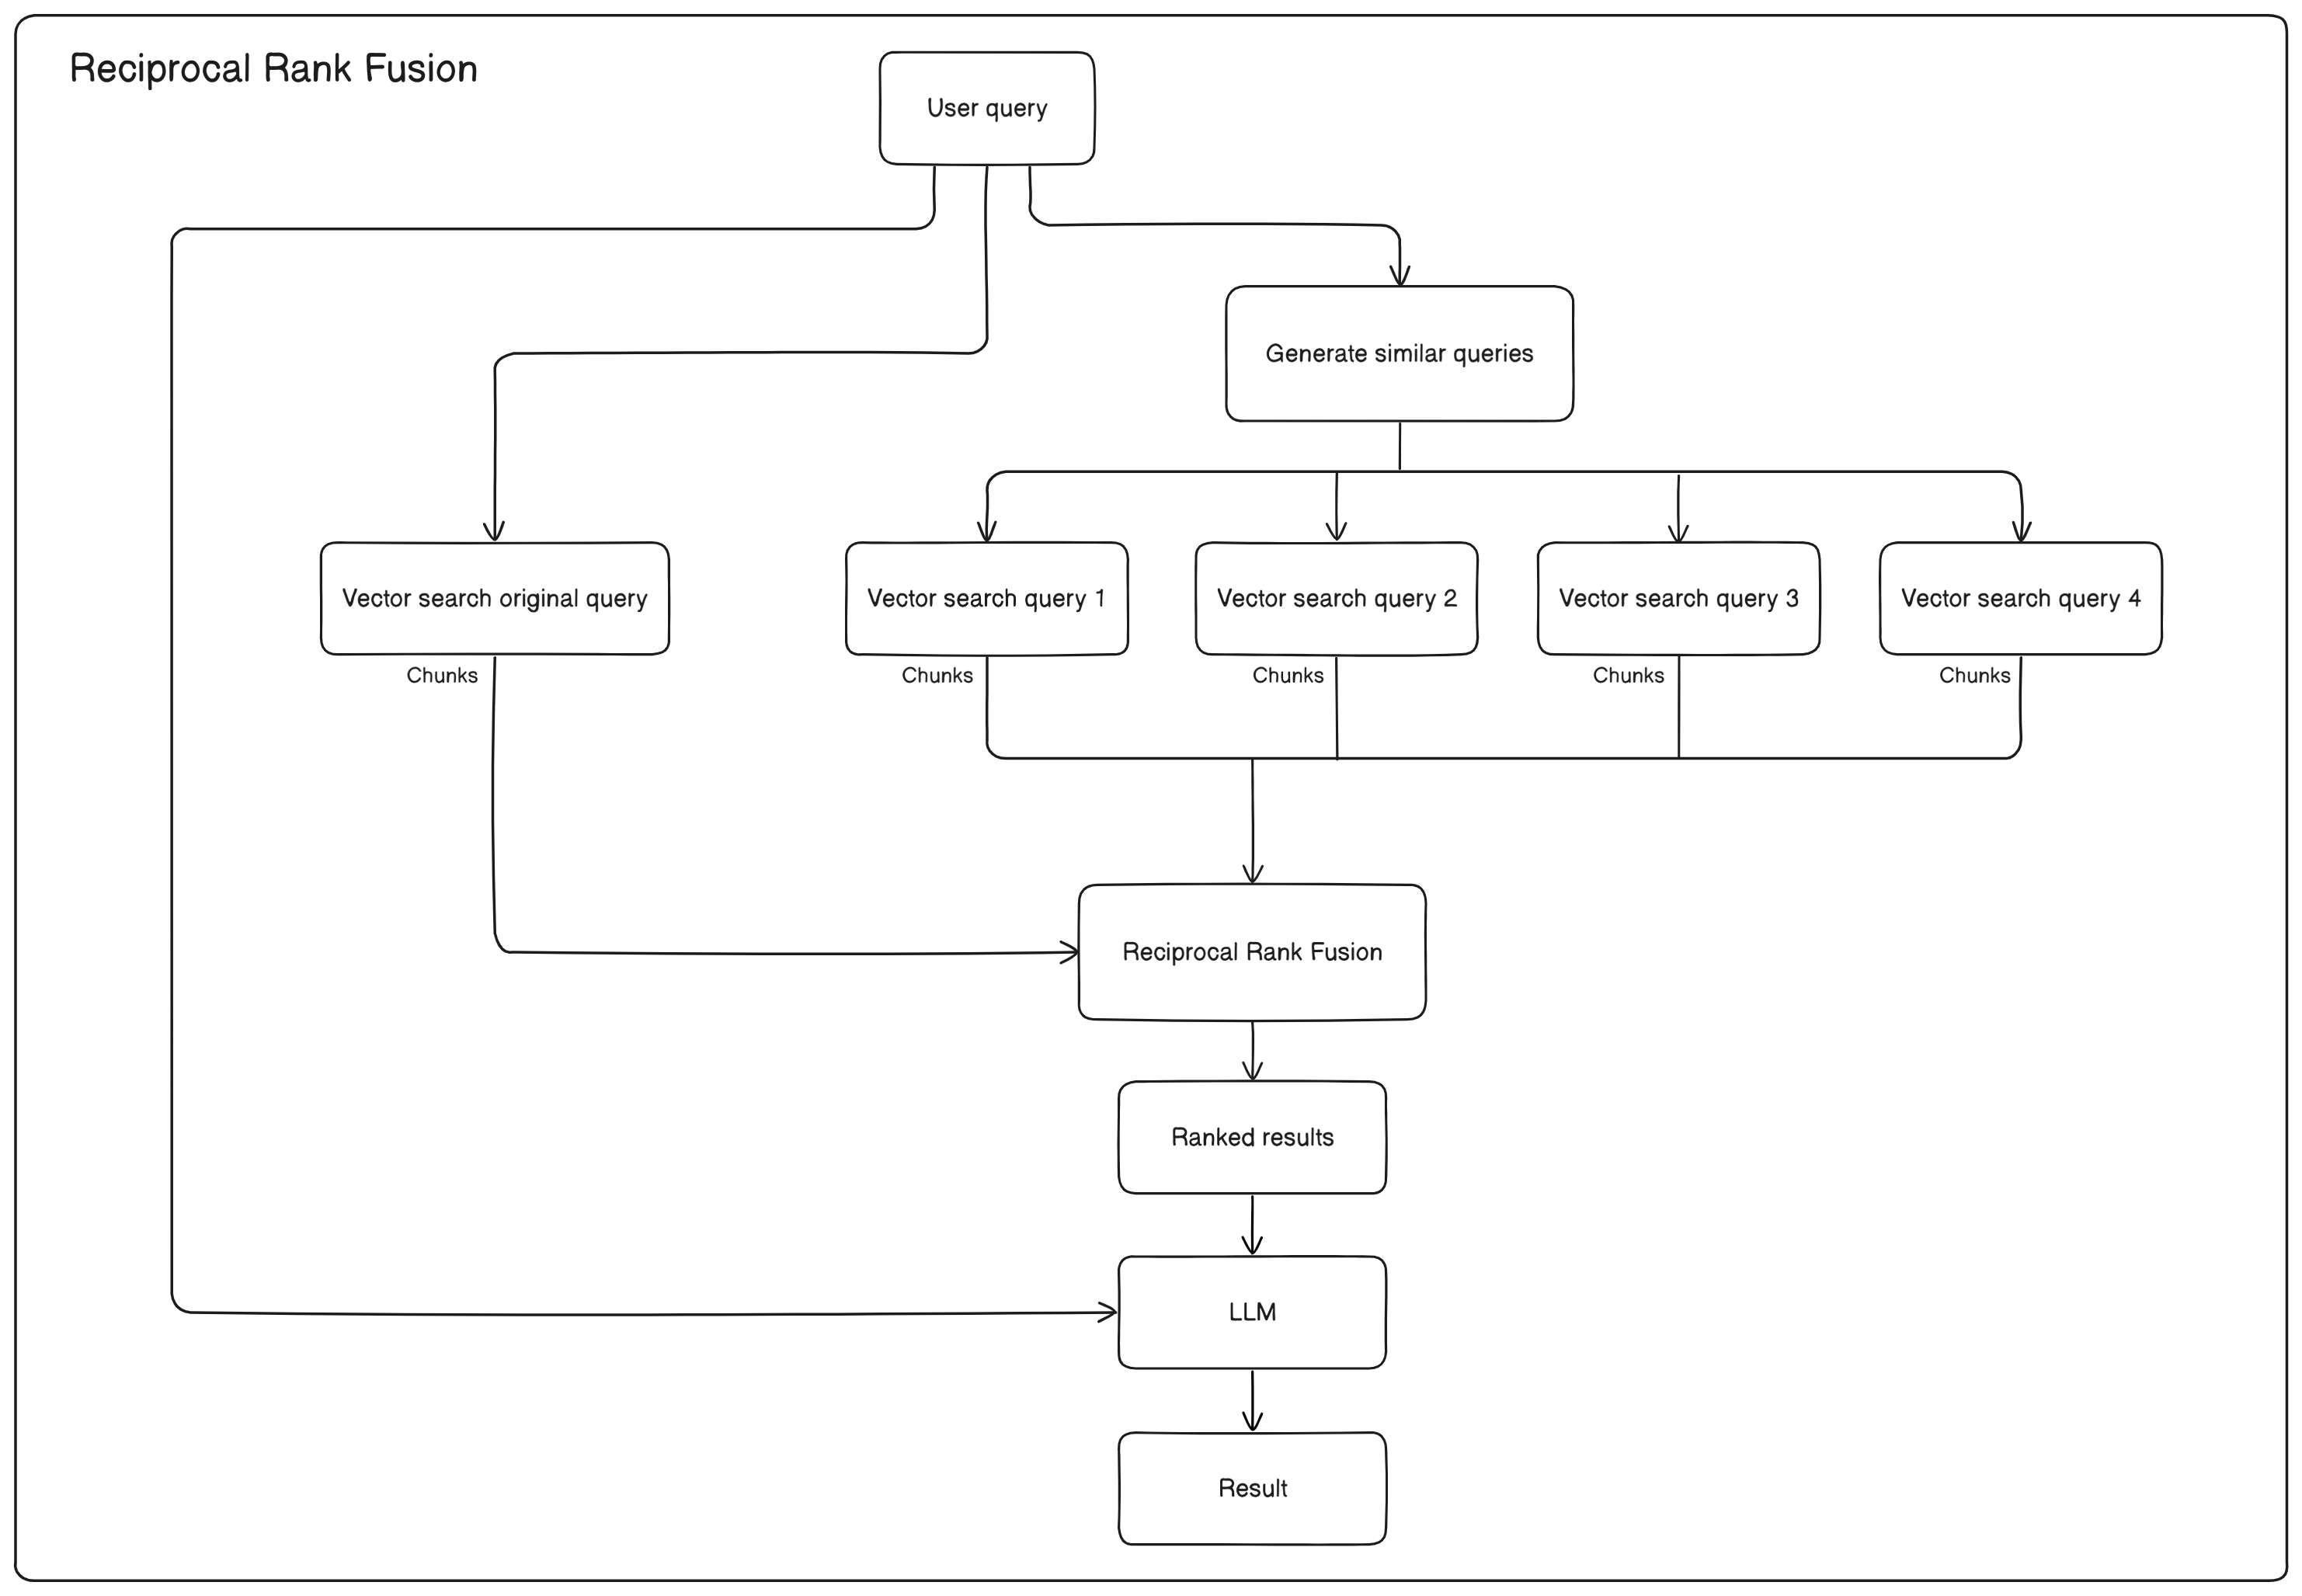
</center>

RAG Fusion is more of like an improvisation on the Multi-Query approach. In Multi-Query approach, we rewrite the user's query in different ways, in the hopes that these variations in the question will enable us to fetch more relevant results from the vector store, where passing the user's query straight to the vector store would yeild limited results. 

But since Multi-Query approach produces multiple relevant chunks, we need to rank them in the order of relevance, with the most relevant chunk at the top. Think of this like when we search for something on Google *(or any other search engine like DuckDuckGo)*, the most relevant is at the top of the page. Google does this by using a number of algorithms like the [Page Rank Algorithm](https://en.wikipedia.org/wiki/PageRank). Fortunately, we have a similar algorithm for ranking our chunks, which is the Reciprocal Rank Function.

We implemented the Multi-Query rewriting above, and over here we'll simply define the Reciprocal Rank Function and re-run the RAG pipeline based on the ranked chunks.

In [40]:
from typing import List

def reciprocal_rank_fusion(results: List[List], k = 60, threshold = 0.06):
    """ Based on the provided list of chunks (documents), rank the chunks based on the score provided by the vector store """

    # Fused scores for each unique document
    fused_scores = {}

    for docs in results:

        # Iterate over each document with it's rank (the rank is assumed as the position in the list)
        for rank, document in enumerate(docs):

            # Convert the document to string (assuming document can be converted to JSON)
            doc_string = dumps(document)

            # If document is not in `fused_scores`, add it to the `fused_scores` with score = 0
            if doc_string not in fused_scores:
                fused_scores[doc_string] = 0

            fused_scores[doc_string] += 1 / (rank + k)
    
    # Sort documents in reverse based on fused scores
    reranked_results = [
        (loads(document), score) 
        for document, score in sorted(fused_scores.items(), key = lambda x: x[1], reverse = True) 

        # Additionally, add a threshold if needed
        if score > threshold
    ]

    return reranked_results

In [41]:
# User query
query = "What are the approaches to Task Decomposition?"

# Retrieval pipeline for our RRF logic
retriever = vectorstore.as_retriever(
    search_type = "similarity_score_threshold",
    search_kwargs = {
        "k": 6,
        "score_threshold": 0.1
    }
)
retrieval_chain = generate_new_queries | retriever.map() | reciprocal_rank_fusion

# Check how many chunks were retrieved
relevant_documents = retrieval_chain.invoke({
    "question" : query
})

print("Number of relevant chunks retrieved: ", len(relevant_documents))

Number of relevant chunks retrieved:  2


c:\Users\Pigeon\anaconda3\envs\rag_env\lib\site-packages\langchain_core\vectorstores\base.py:1083: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), 0.147857785443965), (Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',

Let's take a look at the documents and scores based on our RRF function

In [42]:
relevant_documents

[(Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'),
  0.08333333333333333),
 (Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first 

Now let's start our RAG pipeline with the RRF function

In [43]:
# Same code from Multi-Query approach (above)

# RAG chain with RRF
final_rag_chain = (
    {
        "context"   : retrieval_chain, 
        "question"  : itemgetter("question")
    } 
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in final_rag_chain.stream({"question": query}):
    print(chunk, end="", flush=True)

c:\Users\Pigeon\anaconda3\envs\rag_env\lib\site-packages\langchain_core\vectorstores\base.py:1083: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), 0.1088463031821083), (Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'

The approaches to Task Decomposition include: 

1. Using Chain of Thought (CoT) prompting, which instructs the model to "think step by step" to break down complex tasks into smaller, manageable steps.
2. Implementing the Tree of Thoughts method, which extends CoT by exploring multiple reasoning possibilities at each step and creating a tree structure of thoughts.
3. Employing simple prompting techniques with large language models (LLMs), such as asking for the steps or subgoals needed to achieve a task.
4. Utilizing task-specific instructions, like providing a story outline for writing a novel.
5. Incorporating human inputs to assist in the decomposition process.

Although the final answer generated by our LLM is the same, the ranking of the documents provided as context is different.

In the Multi-Query approach, the documents "Tree of Thoughts (Yao et al. 2023) extends CoT by exploring" and "Overview of a LLM-powered autonomous agent system" were ranked 2 and 3 respectively, but in RRF, the same documents were ranked 1 and 2. With our custom threshold set as 0.06, we were able to focus on the precise documents.

As discussed previously, RRF, when applied to a single source *(like this example, where all documents are fetched from one ChromaDB vector database)*, does not provide much benefit. **RRF works best when multiple sources are involved**, like combining results from different retrieval models or systems (e.g., vector search with semantic similarity and a traditional keyword-based search engine). In such cases, RRF helps merge diverse rankings from different systems to prioritize the most relevant documents. However, when all results come from the same vector store, the documents are already ranked according to the same model, and hence the benefit of RRF diminishes.


## References

- [Query Rewriting for Retrieval-Augmented Large Language Models](https://arxiv.org/pdf/2305.14283)
- [Take a Step Back: Evoking Reasoning via Abstraction in Large Language Models](https://arxiv.org/pdf/2310.06117)
- [LangChain - Query Transformations](https://blog.langchain.dev/query-transformations/)
- [LangChain - How to use the MultiQueryRetriever](https://python.langchain.com/docs/how_to/MultiQueryRetriever/)
- [*PAYWALL* Forget RAG, the Future is RAG-Fusion](https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
- [*UNLOCKED* Forget RAG, the Future is RAG-Fusion](https://freedium.cfd/https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
- [Reciprocal Rank Fusion outperforms Condorcet and individual Rank Learning Methods](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf)